# Determine Costas Array Frequencies, Order 8, For Yaesu Radios
## By Terry Bondy, VA3TYB

In [1]:
%plot --format svg

In [2]:
source("../common/preamble.m")

Last updated: Wednesday 19 February 2020

In [3]:
source("../common/radio.m")

radioFreqAudioBwLow =  200
radioFreqAudioBwHigh =  2600
radioFreqAudioBw =  2400
radioFreqAudioMidBand =  721.11


Want to spread the frequencies equidistant across the audio bandpass for the radio, but have it centered one the geometric center of the audio bandpass for the radio. That means:

 1. $N = 8$,
 1. $costas8Freq_{8} = costas8Freq_{1} + costas8FreqDelta * (N - 1)$
 1. $\frac{costas8Freq_{1}}{radioFreqAudioBwLow} = \frac{radioFreqAudioBwHigh}{costas8Freq_{8}}$
 1. $costas8Freq_{8} < radioFreqAudioBwHigh$
 1. $radioFreqAudioBwLow < costas8Freq_{1}$
 
Using 1, 2, 4, and 5 an upper limit can be set on $costas8FreqDelta$.
$costas8FreqDelta < \frac{radioFreqAudioBwHigh - radioFreqAudioBwLow}{7}$
or 

In [4]:
(radioFreqAudioBwHigh - radioFreqAudioBwLow)/7

ans =  342.86


So let set

In [5]:
global costas8FreqDelta = 300

Substituting into 3. and re-arranging

 * $costas8Freq_{1} \cdot costas8Freq_{8} = radioFreqAudioBwLow \cdot radioFreqAudioBwHigh$
 * $costas8Freq_{1} \cdot (costas8Freq_{1} + 300 \cdot 7) = 200 \cdot 2600$
 * $costas8Freq_{1}^{2} + costas8Freq_{1} \cdot 2100 = 520000$
 
Solving for the positive root provides

In [6]:
roots([1, 2100, -520000])

ans =

  -2323.77
    223.77



Checking

In [7]:
(2323.77-223.77)/7

ans =  300


In [8]:
223.77/radioFreqAudioBwLow

ans =  1.1189


In [9]:
radioFreqAudioBwHigh/2323.77

ans =  1.1189


Setting to a reasonable nearby integer

In [10]:
global costas8FreqsCv = [225:costas8FreqDelta:2325](:)
# global costas8FreqsCv = [300:costas8FreqDelta:2400](:)


Need a frequency ordering. From _Modified Costas Signal, Levanon & Mozeson_ here is one:

In [11]:
global costas8FreqIdxCv = [ 1 8 3 6 2 7 5 4 ](:);

In [12]:
function sigValuesCv = costasBlock (...
   sampleRate, ...
   numPulses = 1, ...
   freqOffset = 0, ...
   FreqIdx, ...
   Freqs ...
)
    sigValuesCv = [ 0 ];

    if (size(FreqIdx) != size(Freqs))
      error("Expecting size(FreqIdx) == size(Freqs)")
    endif
    # Make a CV
    Freqs = Freqs(:);
    FreqIdx = FreqIdx(:);

    nFreqs = rows(Freqs);
    deltaFreq = Freqs(2) - Freqs(1);

    # Rejig the frequency array and offset so have continuous phase/value for this algorithm
    # regardless of the freqs values.
    deltaOffset = Freqs(1) - deltaFreq;
    Freqs = Freqs .- deltaOffset;
    freqOffset += deltaOffset;

    TimeCv = [0:1/sampleRate:numPulses/deltaFreq](:);
    nTimeCv = rows(TimeCv)-1;
    TimeLongCv = [0:1/sampleRate:numPulses*nFreqs/deltaFreq](:);
    OffsetPhaseCv = TimeLongCv * freqOffset;
    for idx = 1:1:nFreqs
        timeLongOffset = (idx-1)*nTimeCv+1;
        PhaseCv = TimeCv*Freqs(FreqIdx(idx)) .+ OffsetPhaseCv(timeLongOffset:timeLongOffset+nTimeCv);
        SigLoopCV = -i * exp(i*2*pi*PhaseCv);
        sigValuesCv = vertcat(sigValuesCv, SigLoopCV(2:end));
    endfor
endfunction

In [13]:
function sigValuesCv = costas8Block (...
   sampleRate, ...
   numPulses = 1, ...
   freqOffset = 0 ...
)
  global costas8FreqsCv;
  global costas8FreqIdxCv;
  sigValuesCv = costasBlock(sampleRate, numPulses, freqOffset, costas8FreqIdxCv, costas8FreqsCv);
endfunction

In [14]:
sampleRate = 1024*300;
values = costas8Block(sampleRate, 2);
size(values)
rows(values)/1024


ans =

   16385       1

ans =  16.001


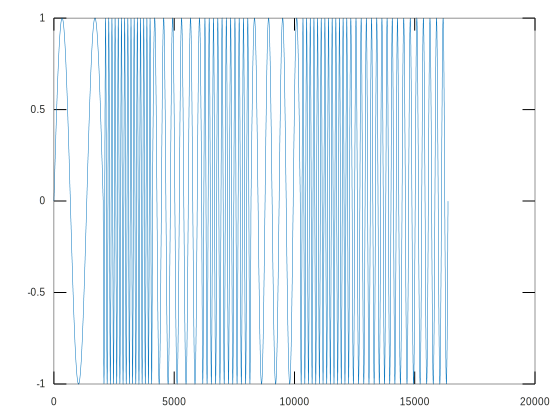

In [15]:
plot(1:1:rows(values),values)
% grid on
% grid minor
% axis([-1 2], "tic")

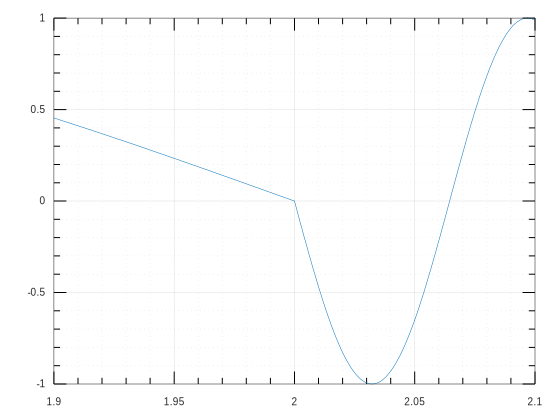

In [16]:
plot(0:300/sampleRate:300*(rows(values)-1)/sampleRate,values)
grid on
grid minor
axis([2-0.1 2+0.1], "tic")

In [17]:
pkg install -forge image


    install at line 30 column 5
    pkg at line 394 column 9
octave: X11 DISPLAY environment variable not set
octave: disabling GUI features
octave: X11 DISPLAY environment variable not set
octave: disabling GUI features
octave: X11 DISPLAY environment variable not set
octave: disabling GUI features
octave: X11 DISPLAY environment variable not set
octave: disabling GUI features
For information about changes from previous versions of the image package, run 'news image'.


In [18]:
template = [0 0.707 0 4 0 0.707 0]
field = [0 0 0 0 0 0 0 0 0.707 0 4 0 0.707 0 0 0 0 0 0 0 4 4+0.707 4 8 4 4+0.707 4 0 0 0 0 0 0 0 0]

template =

   0.00000   0.70700   0.00000   4.00000   0.00000   0.70700   0.00000

field =

 Columns 1 through 8:

   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000

 Columns 9 through 16:

   0.70700   0.00000   4.00000   0.00000   0.70700   0.00000   0.00000   0.00000

 Columns 17 through 24:

   0.00000   0.00000   0.00000   0.00000   4.00000   4.70700   4.00000   8.00000

 Columns 25 through 32:

   4.00000   4.70700   4.00000   0.00000   0.00000   0.00000   0.00000   0.00000

 Columns 33 through 35:

   0.00000   0.00000   0.00000



In [20]:
pkg load image

In [25]:
result = normxcorr2 (template, field)

result =

 Columns 1 through 8:

   0.23339   0.19631   0.34424  -0.34424  -0.19631  -0.23339   0.00000   0.00000

 Columns 9 through 16:

  -0.23339  -0.02005  -0.27852   0.15419  -0.32682   1.00000  -0.32682   0.15419

 Columns 17 through 24:

  -0.27852  -0.02005  -0.23339   0.00000  -0.23339  -0.20877  -0.32569   0.10417

 Columns 25 through 32:

   0.21915  -0.05342   1.00000  -0.05342   0.21915   0.10417  -0.32569  -0.20877

 Columns 33 through 40:

  -0.23339   0.00000   0.00000  -0.23339  -0.19631  -0.34424   0.34424   0.19631

 Column 41:

   0.23339



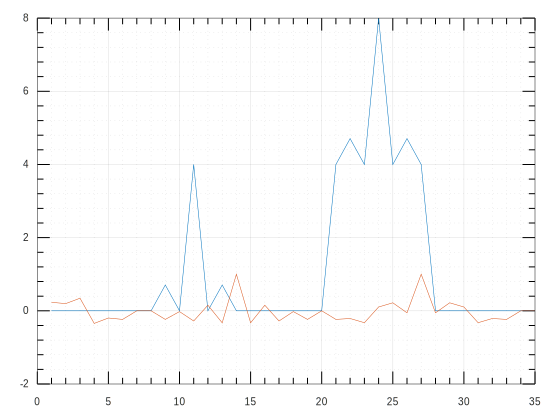

In [28]:
plot(1:1:35, field, result(1:35))
grid on
grid minor

In [22]:
size(ans)

ans =

    1   41



In [23]:
size(field)

ans =

    1   35



In [24]:
size(template)

ans =

   1   7



In [35]:
template = [0 0.707 4 4 0.707 0]
field = [0 0 0 0 0 0 0 0 0.707 4 4 0.707 0 0 0 0 0 0 0 4 4+0.707 8 8 4+0.707 4 0 0 0 0 0 0 0 0 200*0.707 200*4 200*4 200*0.707 0 0 0 0 0 0 0]
result = normxcorr2 (template, field)

template =

   0.00000   0.70700   4.00000   4.00000   0.70700   0.00000

field =

 Columns 1 through 6:

     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000

 Columns 7 through 12:

     0.00000     0.00000     0.70700     4.00000     4.00000     0.70700

 Columns 13 through 18:

     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000

 Columns 19 through 24:

     0.00000     4.00000     4.70700     8.00000     8.00000     4.70700

 Columns 25 through 30:

     4.00000     0.00000     0.00000     0.00000     0.00000     0.00000

 Columns 31 through 36:

     0.00000     0.00000     0.00000   141.40000   800.00000   800.00000

 Columns 37 through 42:

   141.40000     0.00000     0.00000     0.00000     0.00000     0.00000

 Columns 43 and 44:

     0.00000     0.00000

result =

 Columns 1 through 8:

   0.40256   0.49310   0.00000  -0.49310  -0.40256   0.00000   0.00000   0.00000

 Columns 9 through 16:

  -0.40256  -0.45063  -0.42068   0.37772 

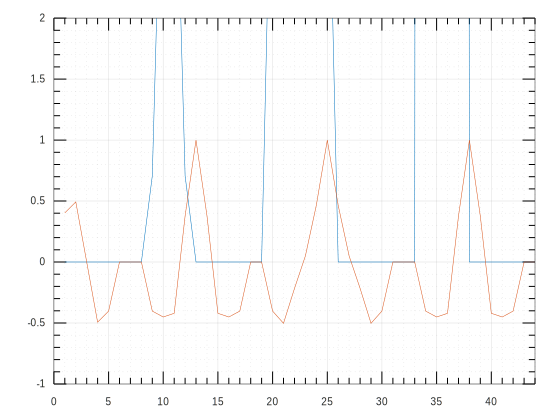

In [37]:
plot(1:1:44, field, result(1:44))
grid on
grid minor
axis([0 44 -1 2], "tic")